# Анализ A/B- теста, проведенного для интернет-магазина

**Цель исследования** — изучить данные о посетителях и их заказах и проверить предложенные гипотезы с целью увеличения выручки.

**Ход исследования**

Данные о предложенных гипотезах, а также о посетителях интернет-магазина и заказах получены из следующих файлов:
- `/datasets/hypothesis.csv` - 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.
- `/datasets/orders.csv` - данные о заказах
- `/datasets/visitors.csv` - данные о пользователях в группах A и B.

Исследование будет включать следующие этапы:
 1. [Обзор и подготовка данных.](#info)
 2. [Приоритизация гипотез](#hypo)
 3. [Анализ А/В- теста](#аbtest)
 4. [Решение.](#decision)

<a id="info"></a>
## Обзор и подготовка данных

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()

In [2]:
hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),  
        pd.read_csv('/datasets/orders.csv'), 
        pd.read_csv('/datasets/visitors.csv'),  
    )

display(hypothesis.head(5))
print()
display(orders.head(5))
print()
display(visitors.head(5))
print()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Структура hypothesis.csv:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Структура orders.csv:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Структура visitors.csv:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

Приведем названия столбцов к нижнему регистру.

In [3]:
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower()

Переименуем некоторые столбцы.

In [4]:
orders = orders.rename(columns={'transactionid':'transaction_id', 'visitorid':'visitor_id'})

In [5]:
print(hypothesis.info())
print()
print(orders.info())
print()
print(visitors.info())
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (tota

In [6]:
print(hypothesis.isna().sum())
print()
print(orders.isna().sum())
print()
print(visitors.isna().sum())
print()

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

date        0
group       0
visitors    0
dtype: int64



Пропуски в данных отсутствуют, проверим наличие дубликатов.

In [7]:
print(hypothesis.duplicated().sum())
print()
print(orders.duplicated().sum())
print()
print(visitors.duplicated().sum())
print()

0

0

0



Мы привели названия столбцов и типы данных к общепринятым и корректным.

Проверка данных показала отсутствие пропусков и дубликатов. Данные готовы для дальнейшего анализа.

<a id="hypo"></a>
## Приоритизация гипотез

Мы имеем в наличии 9 разных гипотез. Чтобы максимизировать ожидаемый рост выручки интернет-магазина, приоритизируем сформулированные гипотезы методами ICE/RICE.

In [8]:
pd.set_option('display.max_colwidth', None)
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [9]:
hypothesis['ICE'] = round((hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'], 2)
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


In [10]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы по ICE - 8, 0 и 7. А по RICE - 7, 2, 0 и 6.

Гипотеза 7 - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" - вырвалась на первое место, т.к. имеет максимальный охват поьльзователей. А у гипотезы 0 - "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" - ключевую роль сыграло самое высокое влияние изменения на пользователей.

<a id="abtest"></a>
## Анализ А/В-теста

### График кумулятивной выручки по группам

In [11]:
dates_groups = orders[['date', 'group']].drop_duplicates()

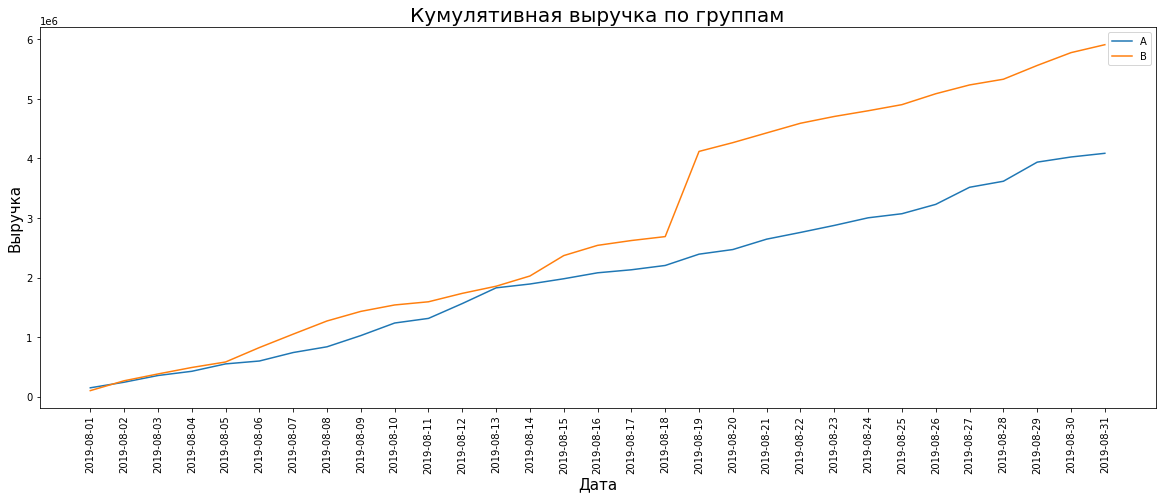

In [12]:
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(20, 7))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.title('Кумулятивная выручка по группам', fontsize=20)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Выручка', fontsize=15)
plt.xticks(rotation = 90)
plt.legend();

Выручка почти равномерно увеличивалась до середины теста. Затем сегмент В резко вырвался вперед и продолжал лидировать. Скорее всего присутствуют выбросы в виде роста числа заказов или появлении очень дорогих заказов.

### График кумулятивного среднего чека по группам

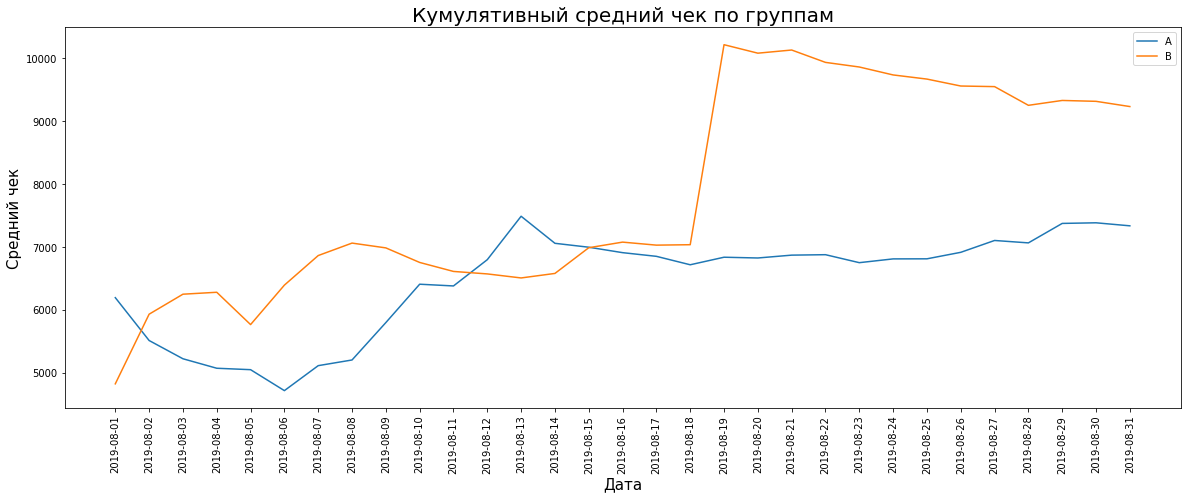

In [13]:
plt.figure(figsize=(20, 7))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.title('Кумулятивный средний чек по группам', fontsize=20)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Средний чек', fontsize=15)
plt.xticks(rotation = 90)
plt.legend();

Кумулятивное значение среднего чека по сегментам сильно колеблется. Необходим анализ выбросов, которые могут так сильно искажать результаты.

### График относительного изменения кумулятивного среднего чека группы B к группе A

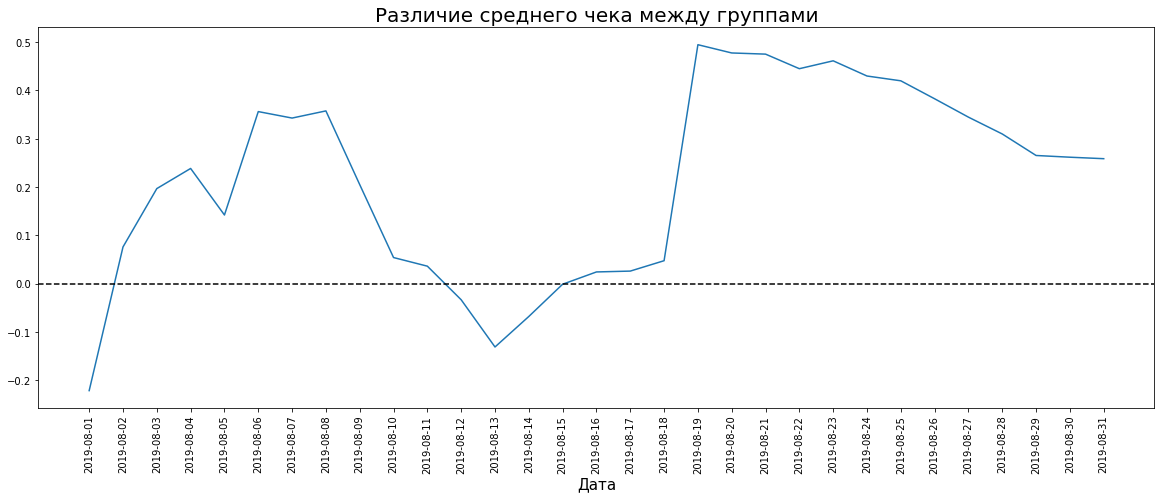

In [14]:
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(20, 7))
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)
plt.title('Различие среднего чека между группами', fontsize=20)
plt.xlabel('Дата', fontsize=15)
plt.xticks(rotation = 90)
plt.axhline(y=0, color='black', linestyle='--');

В нескольких точках график различия между сегментами значительно и резко «скачет». Вероятно, тогда и были совершены аномальные заказы.

### График кумулятивного среднего количества заказов по группам

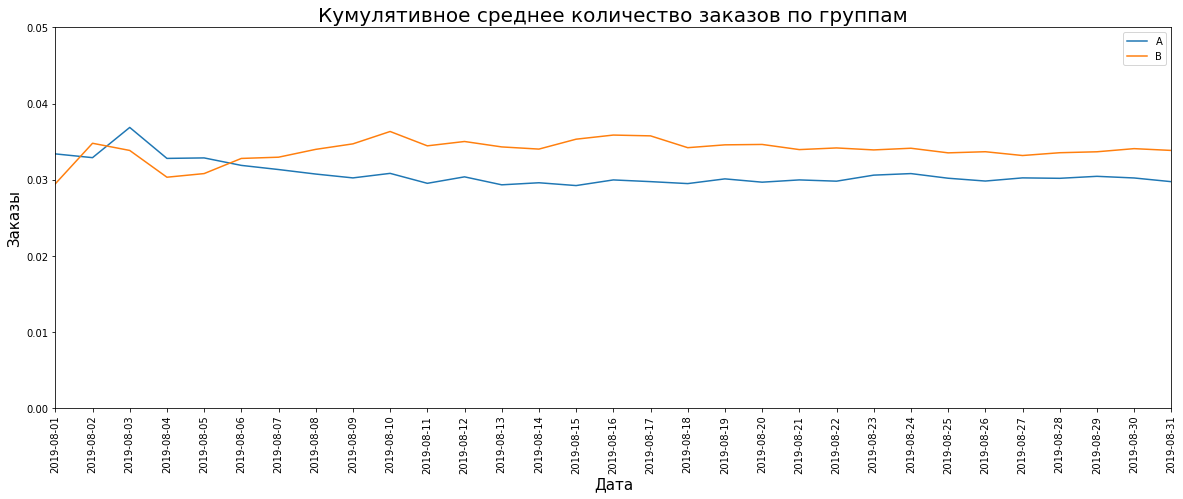

In [15]:
cumulative_data['mean'] = cumulative_data['orders']/cumulative_data['visitors']
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

plt.figure(figsize=(20, 7))
plt.plot(cumulative_data_a['date'], cumulative_data_a['mean'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['mean'], label='B')
plt.title('Кумулятивное среднее количество заказов по группам', fontsize=20)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Заказы', fontsize=15)
plt.xticks(rotation = 90)
plt.axis(["2019-08-01", '2019-08-31', 0, 0.05])
plt.legend();

Сначала лидировал сегмент А, но затем вперед вырвался сегмент В и остался лидером, зафиксировавшись примерно у одного значения.

### График относительного изменения кумулятивного среднего количества заказов группы B к группе A

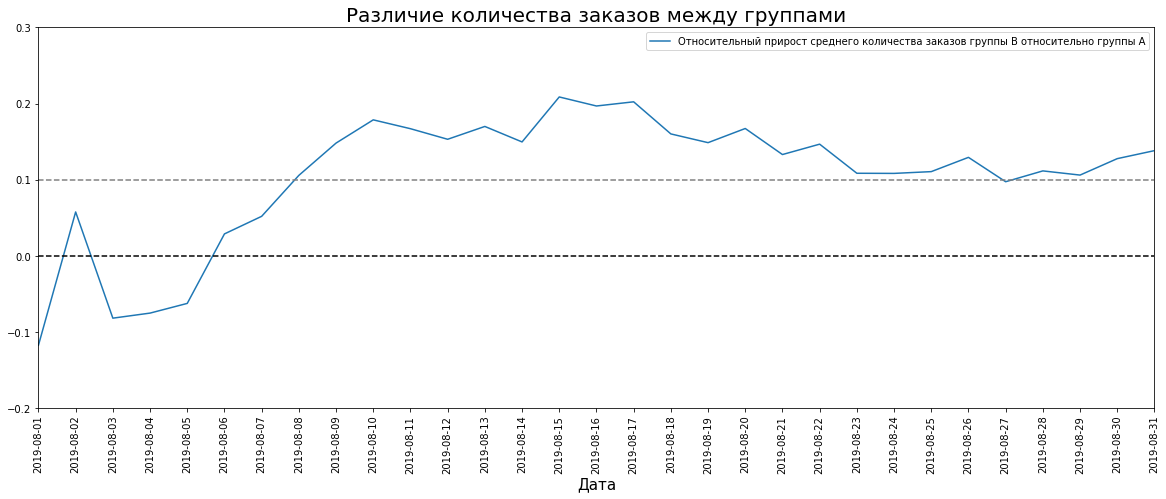

In [16]:
merged_cumulative_mean = cumulative_data_a[['date','mean']].merge(cumulative_data_b[['date','mean']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(20, 7))
plt.plot(merged_cumulative_mean['date'], merged_cumulative_mean['meanB']/merged_cumulative_mean['meanA']-1, label="Относительный прирост среднего количества заказов группы B относительно группы A")
plt.legend()
plt.title('Различие количества заказов между группами', fontsize=20)
plt.xlabel('Дата', fontsize=15)
plt.xticks(rotation = 90)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.2, 0.3]);

В начале группа В проигрывала, но после резкого роста становилась все лучше и лучше группы А, либо зафикисировалась около прироста в 10%.

### Точечный график количества заказов по пользователям

In [17]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns = ['user_id', 'orders']
print(orders_by_users.sort_values(by='orders', ascending=False).head(10)) 

         user_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


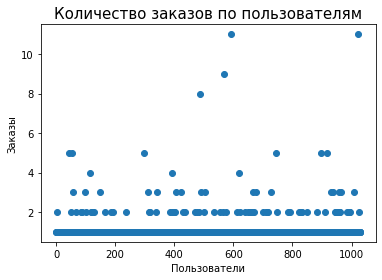

In [18]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders'])
plt.title('Количество заказов по пользователям', fontsize=15)
plt.xlabel('Пользователи', fontsize=10)
plt.ylabel('Заказы', fontsize=10);

На графике видно много пользователей с 2-3 заказами. Пока их точная доля не ясна, нельзя сказать, что это аномалии.

### 95-й и 99-й перцентили количества заказов на пользователя

In [19]:
print(np.percentile(orders_by_users['orders'], [95, 99])) 

[2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказа, и 1% пользователей заказывали более 4 раз.
Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

### Точечный график стоимостей заказов

In [20]:
print(orders.sort_values(by='revenue', ascending=False).head(10))

      transaction_id  visitor_id        date  revenue group
425        590470918  1920142716  2019-08-19  1294500     B
1196      3936777065  2108080724  2019-08-15   202740     B
858        192721366  1316129916  2019-08-27    93940     A
1136       666610489  1307669133  2019-08-13    92550     A
744       3668308183   888512513  2019-08-27    86620     B
682       1216533772  4266935830  2019-08-29    78990     B
662       1811671147  4266935830  2019-08-29    78990     A
743       3603576309  4133034833  2019-08-09    67990     A
1103      1348774318  1164614297  2019-08-12    66350     A
1099       316924019   148427295  2019-08-12    65710     A


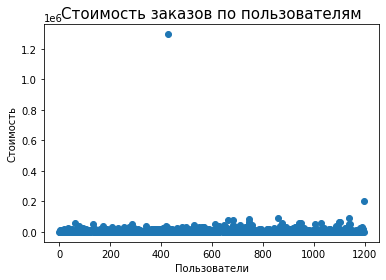

In [21]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов по пользователям', fontsize=15)
plt.xlabel('Пользователи', fontsize=10)
plt.ylabel('Стоимость', fontsize=10);

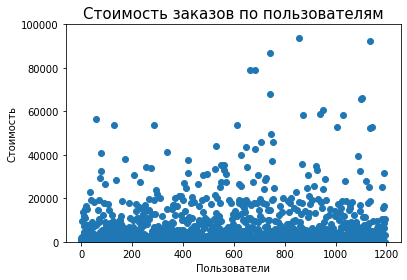

In [22]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylim([0, 100000])
plt.title('Стоимость заказов по пользователям', fontsize=15)
plt.xlabel('Пользователи', fontsize=10)
plt.ylabel('Стоимость', fontsize=10);

На первом графике четко выделяются 2 очень дорогих заказа. Основная масса заказов не дороже 100 000. При ближайшем рассмотрении (на втором графике) видно, что редкие заказы бывают дороже 40 000. Необходимо более точно посмотреть крайние значения.

### 95-й и 99-й перцентили стоимости заказов

In [23]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более 5% заказов дороже 28 000 и не более 1% дороже 58 234 рублей. Выберем сумму заказа в 50 000 за верхнюю границу и отсеим аномальные заказы по ней. 

### Статистическая значимость различий в среднем количестве заказов между группами по «сырым» данным

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.

In [24]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['user_id', 'orders'] 

In [25]:
sample_a = pd.concat([orders_by_users_a['orders'],pd.Series(0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders_by_users_a['orders'])), name='orders')],axis=0)
sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders_by_users_b['orders'])), name='orders')],axis=0)

print('P-value:', "{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))
print('Различие в среднем количестве заказов:', "{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

P-value: 0.017
Различие в среднем количестве заказов: 0.138


P-value значительно меньше 0.05, поэтому нулевую гипотезу отвергаем. Анализ "сырых данных" сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы В к группе А равен 13.8%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [26]:
print('P-value:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Различие в среднем чеке:', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.729
Различие в среднем чеке: 0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Относительное различие среднего чека между сегментами составляет 25.9%.

### Статистическая значимость различий в среднем количестве заказов между группами по «очищенным» данным

Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 50 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами.

In [27]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 3]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 3]['user_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > 50000]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print(abnormal_users.shape[0])

1099    148427295
18      199603092
23      237748145
1137    759473111
949     887908475
dtype: int64
26


Всего 26 аномалий.

In [28]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('P-value:', '{0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Различие в среднем количестве заказов:', '{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1)) 

P-value: 0.011
Различие в среднем количестве заказов: 0.158


Результаты по среднему количеству заказов практически не изменились. Как и в случае с сырыми данными, статистическая значимость достигнута. Группа В значительно лучше группы А.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [29]:
print('P-value:', 
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Различие в среднем чеке:', 
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value: 0.819
Различие в среднем чеке: 0.024


P-value увеличился, а разница между сегментами сократилась с 25% до 2%. После удаления шумов стало еще лучше видно отсутствие значимых различий в среднем чеке.

<a id="decision"></a>
### Решение

Имеющиеся факты:
- Нет статистически значимого различия по среднему количеству заказов между группами ни по «сырым», ни по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. После удаления аномалий разница в чеке сократилась до 2%, что при таком высоком уровне значимости не является значимым;
- График различия среднего чека группы B к группе A колеблется. Сделать из этого графика определённые выводы нельзя;
- График различия среднего количества заказов группы B к группе A сообщает, что результаты группы B лучше группы A: имеют незначительную тенденцию к росту, либо зафиксировались около среднего значения.

**Исходя из фактов выше стоит остановить тест и зафиксировать победу группы В**: средний чек группы В мало отличается, но количество заказов растет или остается на уровне прироста в 10%, что в итоге приведет к увеличению выручки.